#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행 (필수)
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교 (권장)
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교 (선택)
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [14]:
# !pip install keras

In [15]:
# !pip install tensorflow

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [17]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [21]:
path = "data01_train.csv"

In [22]:
data = pd.read_csv(path)

#### 2) 기본 정보 조회

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [25]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [26]:
data.shape

(5881, 563)

In [27]:
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [31]:
data.isna().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

In [32]:
data = data.drop(columns='subject')

In [33]:
target = 'Activity'
x_1 = data.drop(columns=target)
y_1 = data.loc[:,target]

### (2) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [36]:
# 원-핫 인코딩
y_1_encoded = pd.get_dummies(y_1)

print(y_1_encoded)

      LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
0      False    False      True    False               False             False
1       True    False     False    False               False             False
2      False    False      True    False               False             False
3      False    False     False     True               False             False
4      False    False     False    False                True             False
...      ...      ...       ...      ...                 ...               ...
5876   False     True     False    False               False             False
5877   False    False     False    False               False              True
5878    True    False     False    False               False             False
5879   False    False     False    False               False              True
5880   False     True     False    False               False             False

[5881 rows x 6 columns]


In [37]:
from sklearn.model_selection import train_test_split

x_train_minmax,x_val_minmax,y_train_minmax,y_val_minmax = train_test_split(x_1,y_1_encoded,test_size = 0.2,stratify=y_1_encoded,random_state=1)
x_train_standard,x_val_standard,y_train_standard,y_val_standard = train_test_split(x_1,y_1_encoded,test_size = 0.2,stratify=y_1_encoded,random_state=1)

In [38]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

x_train_minmax = scaler1.fit_transform(x_train_minmax)
x_val_minmax = scaler1.transform(x_val_minmax)
x_train_standard = scaler2.fit_transform(x_train_standard)
x_val_standard = scaler2.transform(x_val_standard)

### (3) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

### (4) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [45]:
nfeatures_minmax = x_train_minmax.shape[1]
nfeatures_standard = x_train_standard.shape[1]

print(x_train_minmax.shape[1])
print(x_train_standard.shape[1])
print(y_train_standard.shape)  # (샘플 수, 6)
print(y_train_minmax.shape)    # (샘플 수, 6)

561
561
(4704, 6)
(4704, 6)


In [46]:
clear_session()

model = Sequential([Input(shape=(nfeatures_minmax,)),
                   Dense(6,activation='softmax')])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6)                   │           3,372 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
model.compile(optimizer=Adam(learning_rate=0.001),loss = 'categorical_crossentropy')
hist1_standard = model.fit(x_train_standard,y_train_standard,epochs=20,validation_split=0.2).history
hist1_minmax = model.fit(x_train_minmax,y_train_minmax,epochs=20,validation_split=0.2).history

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0066 - val_loss: 0.3609
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2760 - val_loss: 0.2527
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1834 - val_loss: 0.2085
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1821
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1230 - val_loss: 0.1616
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1052 - val_loss: 0.1456
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0956 - val_loss: 0.1335
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0807 - val_loss: 0.1290
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0779 - val_loss: 0.1230
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0737 - val_loss: 0.1164
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0673 - val_loss: 0.1174
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

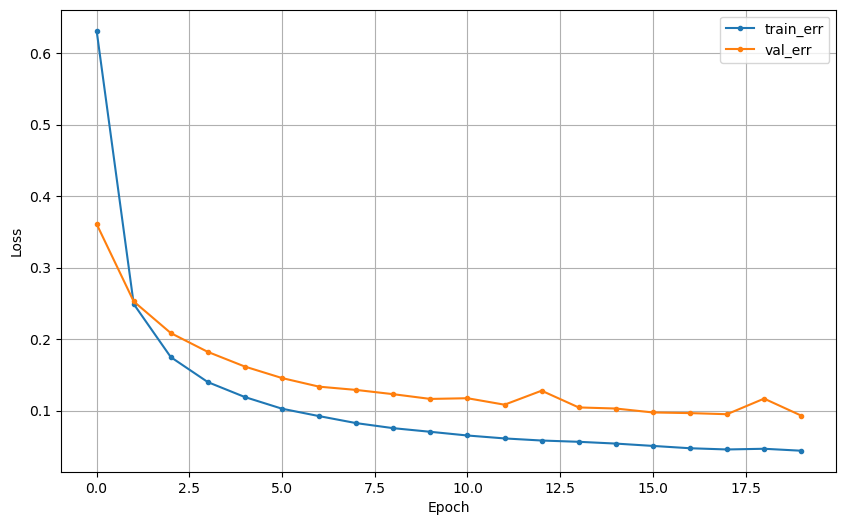

In [48]:
dl_history_plot(hist1_standard)

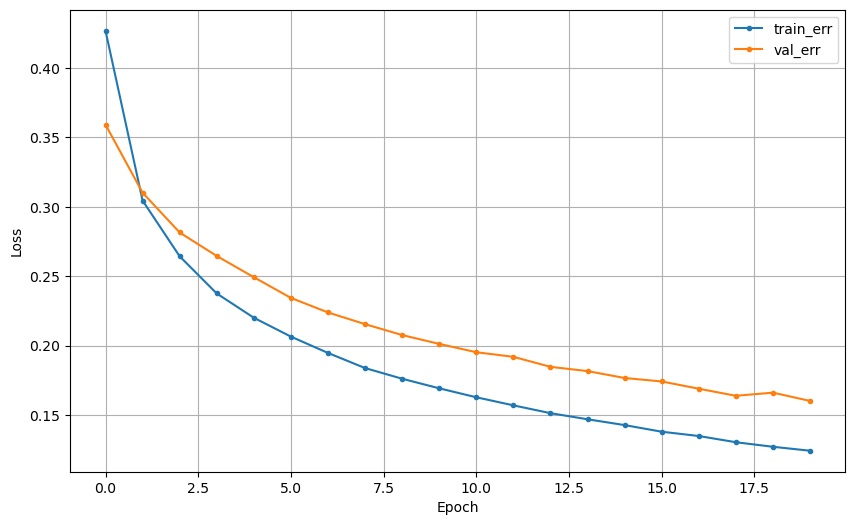

In [49]:
dl_history_plot(hist1_minmax)

In [50]:
# 예측 수행
pred_minmax = model.predict(x_val_minmax)

# 예측 결과를 정수 레이블로 변환
pred_1 = pred_minmax.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_minmax.values.argmax(axis=1)


print(y_val_labels)
print(pred_1)
print(confusion_matrix(y_val_labels, pred_1))
print(classification_report(y_val_labels, pred_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[5 1 4 ... 0 4 2]
[5 1 4 ... 0 4 2]
[[223   0   0   0   0   0]
 [  0 191  15   0   0   0]
 [  0  21 197   0   0   0]
 [  0   0   0 199   1   0]
 [  0   0   0   1 156   1]
 [  0   0   0   6   1 165]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.90      0.93      0.91       206
           2       0.93      0.90      0.92       218
           3       0.97      0.99      0.98       200
           4       0.99      0.99      0.99       158
           5       0.99      0.96      0.98       172

    accuracy                           0.96      1177
   macro avg       0.96      0.96      0.96      1177
weighted avg       0.96      0.96      0.96      1177



In [51]:
# 예측 수행
pred_standard = model.predict(x_val_standard)

# 예측 결과를 정수 레이블로 변환
pred_1 = pred_standard.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_standard.values.argmax(axis=1)

print(y_val_labels)
print(confusion_matrix(y_val_labels, pred_1))
print(classification_report(y_val_labels, pred_1))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[5 1 4 ... 0 4 2]
[[222   0   0   0   0   1]
 [  0 145  61   0   0   0]
 [  0   3 215   0   0   0]
 [  0   0   0 186   9   5]
 [  0   0   0   0 158   0]
 [  0   0   0   3   7 162]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.98      0.70      0.82       206
           2       0.78      0.99      0.87       218
           3       0.98      0.93      0.96       200
           4       0.91      1.00      0.95       158
           5       0.96      0.94      0.95       172

    accuracy                           0.92      1177
   macro avg       0.94      0.93      0.92      1177
weighted avg       0.94      0.92      0.92      1177



### (2) 모델2

- Basic Model에서 Hidden Layer만 늘린 경우

In [54]:
nfeatures_minmax

561

In [55]:
clear_session()

model2 = Sequential([Input(shape=(nfeatures_minmax,)),
                   Dense(256,activation='relu'),
                   Dense(128,activation='relu'),
                   Dense(64,activation='relu'),
                   Dense(32,activation='relu'),
                   Dense(16,activation='relu'),
                   Dense(6,activation='softmax')])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         143,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,734 (733.34 KB)

 Trainable params: 187,734 (733.34 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model2.compile(optimizer=Adam(learning_rate=0.001),loss = 'categorical_crossentropy')
hist2_standard = model2.fit(x_train_standard,y_train_standard,epochs=20,validation_split=0.2).history
hist2_minmax = model2.fit(x_train_minmax,y_train_minmax,epochs=20,validation_split=0.2).history

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.7331 - val_loss: 0.2172
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1228 - val_loss: 0.1154
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0826 - val_loss: 0.1091
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0463 - val_loss: 0.2246
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0559 - val_loss: 0.2183
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0602 - val_loss: 0.1086
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0273 - val_loss: 0.1484
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0403 - val_loss: 0.1000
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0228 - val_loss: 0.0911
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0150 - val_loss: 0.1062
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0219 - val_loss: 0.1285
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/

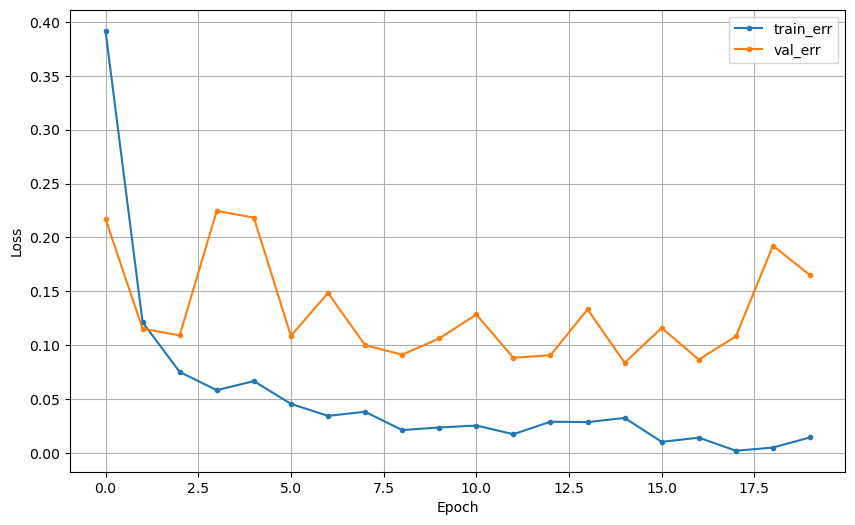

In [57]:
dl_history_plot(hist2_standard)

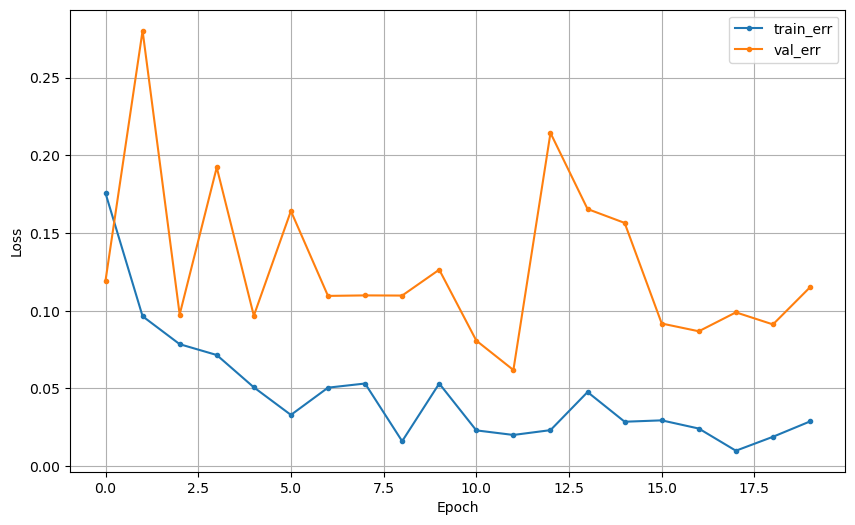

In [58]:
dl_history_plot(hist2_minmax)

In [59]:
# 예측 수행
pred_standard2 = model2.predict(x_val_standard)

# 예측 결과를 정수 레이블로 변환
pred_2 = pred_standard2.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_standard.values.argmax(axis=1)

print(y_val_labels)
print(pred_2)
print(confusion_matrix(y_val_labels, pred_2))
print(classification_report(y_val_labels, pred_2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
[5 1 4 ... 0 4 2]
[5 1 4 ... 0 4 2]
[[223   0   0   0   0   0]
 [  1 105 100   0   0   0]
 [  0   1 217   0   0   0]
 [  0   0   0 190   7   3]
 [  0   0   0   0 158   0]
 [  0   0   0   4   5 163]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.99      0.51      0.67       206
           2       0.68      1.00      0.81       218
           3       0.98      0.95      0.96       200
           4       0.93      1.00      0.96       158
           5       0.98      0.95      0.96       172

    accuracy                           0.90      1177
   macro avg       0.93      0.90      0.90      1177
weighted avg       0.92      0.90      0.89      1177



In [60]:
# 예측 수행
pred_minmax2 = model2.predict(x_val_minmax)

# 예측 결과를 정수 레이블로 변환
pred_2 = pred_minmax2.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_minmax.values.argmax(axis=1)

print(y_val_labels)
print(pred_2)
print(confusion_matrix(y_val_labels, pred_2))
print(classification_report(y_val_labels, pred_2))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[5 1 4 ... 0 4 2]
[5 1 4 ... 0 4 2]
[[223   0   0   0   0   0]
 [  0 180  26   0   0   0]
 [  0   2 216   0   0   0]
 [  0   0   0 200   0   0]
 [  0   0   0   1 155   2]
 [  0   0   0   1   0 171]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       0.99      0.87      0.93       206
           2       0.89      0.99      0.94       218
           3       0.99      1.00      1.00       200
           4       1.00      0.98      0.99       158
           5       0.99      0.99      0.99       172

    accuracy                           0.97      1177
   macro avg       0.98      0.97      0.97      1177
weighted avg       0.97      0.97      0.97      1177



### (3) 모델3

- 원 핫 인코딩(6) -> target을 두 개의 클래스(2)로 분류 후 학습

In [63]:
y_1_binary = data['Activity'].map({'STANDING':0,
                                         'SITTING':0,
                                         'LAYING':0,
                                         'WALKING':1,
                                         'WALKING_UPSTAIRS':1,
                                         'WALKING_DOWNSTAIRS':1})
y_1_binary

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: Activity, Length: 5881, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split

x_train_minmax,x_val_minmax,y_train_minmax,y_val_minmax = train_test_split(x_1,y_1_binary,test_size = 0.2,stratify=y_1_binary,random_state=1)
x_train_standard,x_val_standard,y_train_standard,y_val_standard = train_test_split(x_1,y_1_binary,test_size = 0.2,stratify=y_1_binary,random_state=1)

In [65]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

x_train_minmax = scaler1.fit_transform(x_train_minmax)
x_val_minmax = scaler1.fit_transform(x_val_minmax)
x_train_standard = scaler2.fit_transform(x_train_standard)
x_val_standard = scaler2.fit_transform(x_val_standard)

In [66]:
nfeatures_minmax = x_train_minmax.shape[1]
nfeatures_standard = x_train_standard.shape[1]

print(x_train_minmax.shape[1])
print(x_train_standard.shape[1])
print(y_train_standard.shape)  # (샘플 수, 1)
print(y_train_minmax.shape)    # (샘플 수, 1)

561
561
(4704,)
(4704,)


In [67]:
clear_session()

model3 = Sequential([Input(shape=(nfeatures_minmax,)),
                   Dense(1,activation='sigmoid')])
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │             562 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 562 (2.20 KB)

 Trainable params: 562 (2.20 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model3.compile(optimizer=Adam(learning_rate=0.001),loss = 'binary_crossentropy')
hist3_standard = model3.fit(x_train_standard,y_train_standard,epochs=20,validation_split=0.2).history
hist3_minmax = model3.fit(x_train_minmax,y_train_minmax,epochs=20,validation_split=0.2).history

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0601 - val_loss: 0.0059
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - val_loss: 0.0030
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7361e-04 - val_loss: 8.7273e-04
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0937e-04 - val_loss: 7.3538e-04
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4285e-04 - val_loss: 6.3983e-04
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4128e-04 - val_loss: 5.3790e-04
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7194e-04 - val_loss: 4.9897e-04
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4222e-04 - val_loss: 4.2098e-04
Epo

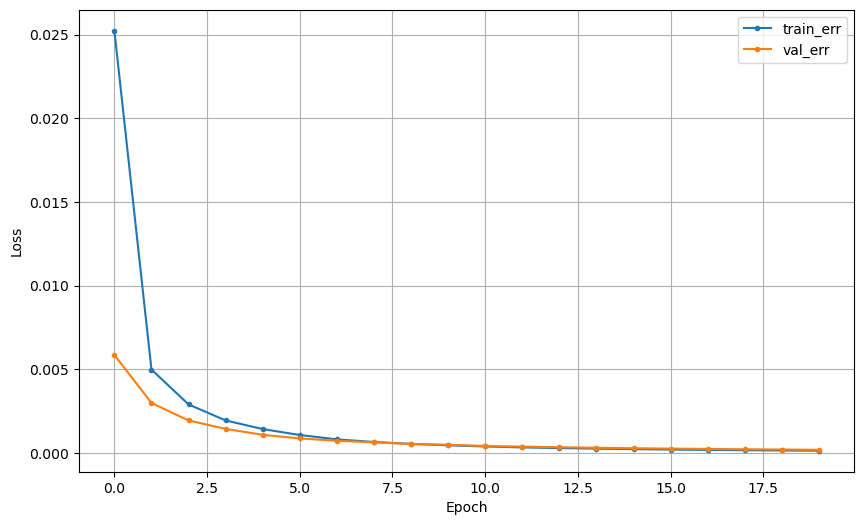

In [69]:
dl_history_plot(hist3_standard)

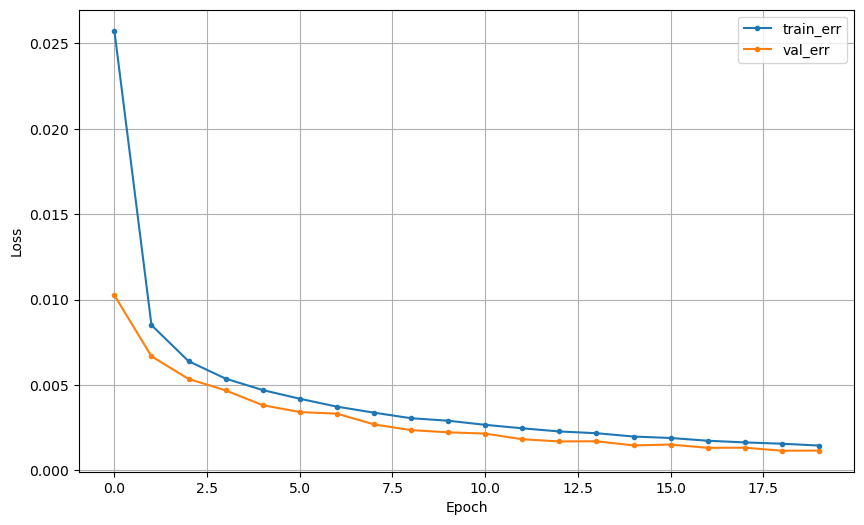

In [70]:
dl_history_plot(hist3_minmax)

In [71]:
# 예측 수행
pred_minmax3 = model3.predict(x_val_minmax)

# 예측 결과를 정수 레이블로 변환
pred_3 = np.where(pred_minmax3 >= .5, 1, 0)

print(confusion_matrix(y_val_minmax, pred_3))
print(classification_report(y_val_minmax, pred_3))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[646   1]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



In [72]:
# 예측 수행
pred_standard3 = model3.predict(x_val_standard)

# 예측 결과를 정수 레이블로 변환
pred_3 = np.where(pred_standard3 >= .5, 1, 0)

print(confusion_matrix(y_val_standard, pred_3))
print(classification_report(y_val_standard, pred_3))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[646   1]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (4) 모델4

In [74]:
from sklearn.model_selection import train_test_split

x_train_minmax,x_val_minmax,y_train_minmax,y_val_minmax = train_test_split(x_1,y_1_encoded,test_size = 0.2,stratify=y_1_encoded,random_state=1)
x_train_standard,x_val_standard,y_train_standard,y_val_standard = train_test_split(x_1,y_1_encoded,test_size = 0.2,stratify=y_1_encoded,random_state=1)

In [75]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

x_train_minmax = scaler1.fit_transform(x_train_minmax)
x_val_minmax = scaler1.fit_transform(x_val_minmax)
x_train_standard = scaler2.fit_transform(x_train_standard)
x_val_standard = scaler2.fit_transform(x_val_standard)

In [76]:
clear_session()

model4 = Sequential([Input(shape=(nfeatures_minmax,)),
                   Dense(16,activation='relu'),
                   Dense(10,activation='relu'),
                   Dense(6,activation='softmax')])
model4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │           8,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             170 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,228 (36.05 KB)

 Trainable params: 9,228 (36.05 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
model4.compile(optimizer=Adam(learning_rate=0.001),loss = 'categorical_crossentropy')
hist4_standard = model4.fit(x_train_standard,y_train_standard,epochs=20,validation_split=0.2).history
hist4_minmax = model4.fit(x_train_minmax,y_train_minmax,epochs=20,validation_split=0.2).history

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.2210 - val_loss: 0.4198
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2902 - val_loss: 0.2592
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1586 - val_loss: 0.1724
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1079 - val_loss: 0.1494
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0811 - val_loss: 0.1319
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0643 - val_loss: 0.1257
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0613 - val_loss: 0.1119
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0472 - val_loss: 0.1093
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0431 - val_loss: 0.1005
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0455 - val_loss: 0.0983
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0377 - val_loss: 0.0968
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

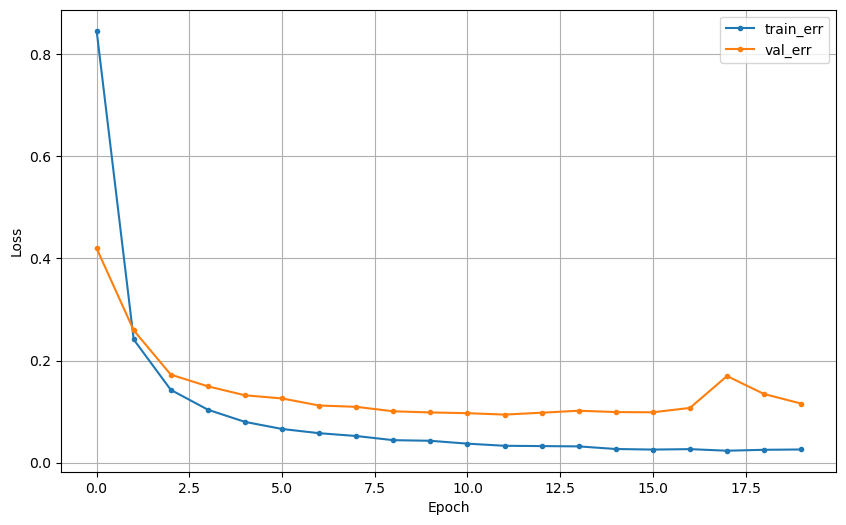

In [78]:
dl_history_plot(hist4_standard)

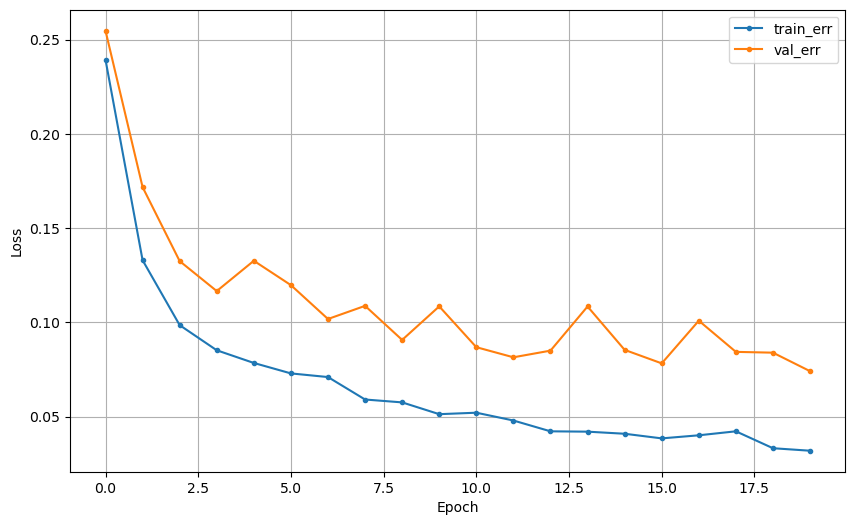

In [79]:
dl_history_plot(hist4_minmax)

In [80]:
# 예측 수행
pred_standard4 = model4.predict(x_val_standard)

# 예측 결과를 정수 레이블로 변환
pred_4 = pred_standard4.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_standard.values.argmax(axis=1)

print(y_val_labels)
print(pred_4)
print(confusion_matrix(y_val_labels, pred_4))
print(classification_report(y_val_labels, pred_4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[5 1 4 ... 0 4 2]
[5 1 4 ... 0 4 2]
[[221   2   0   0   0   0]
 [  0 206   0   0   0   0]
 [  0  38 180   0   0   0]
 [  0   0   0 182  12   6]
 [  0   0   0   0 158   0]
 [  0   0   0   1  22 149]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       223
           1       0.84      1.00      0.91       206
           2       1.00      0.83      0.90       218
           3       0.99      0.91      0.95       200
           4       0.82      1.00      0.90       158
           5       0.96      0.87      0.91       172

    accuracy                           0.93      1177
   macro avg       0.94      0.93      0.93      1177
weighted avg       0.94      0.93      0.93      1177



In [81]:
# 예측 수행
pred_standard4 = model4.predict(x_val_standard)

# 예측 결과를 정수 레이블로 변환
pred_4 = pred_standard4.argmax(axis=1)

# y_val_minmax를 Numpy 배열로 변환한 후 정수 레이블로 변환
y_val_labels = y_val_standard.values.argmax(axis=1)

print(y_val_labels)
print(pred_4)
print(confusion_matrix(y_val_labels, pred_4))
print(classification_report(y_val_labels, pred_4))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[5 1 4 ... 0 4 2]
[5 1 4 ... 0 4 2]
[[221   2   0   0   0   0]
 [  0 206   0   0   0   0]
 [  0  38 180   0   0   0]
 [  0   0   0 182  12   6]
 [  0   0   0   0 158   0]
 [  0   0   0   1  22 149]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       223
           1       0.84      1.00      0.91       206
           2       1.00      0.83      0.90       218
           3       0.99      0.91      0.95       200
           4       0.82      1.00      0.90       158
           5       0.96      0.87      0.91       172

    accuracy                           0.93      1177
   macro avg       0.94      0.93      0.93      1177
weighted avg       0.94      0.93      0.93      1177



# 모델 5 (미완)

- 정적 데이터 안에서 다중분류 + 동적 데이터 안에서 다중분류 => 하나의 모델로 합치기

In [84]:
# 데이터 전처리
static_data = data[y_1.isin(['SITTING', 'LAYING', 'STANDING'])]
dynamic_data = data[y_1.isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]

# 타겟 및 입력 데이터 설정
target = 'Activity'
static_x = static_data.drop(columns=target)
static_y = static_data[target]
dynamic_x = dynamic_data.drop(columns=target)
dynamic_y = dynamic_data[target]

# 레이블 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
static_y_encoded = pd.get_dummies(label_encoder.fit_transform(static_y))
dynamic_y_encoded = pd.get_dummies(label_encoder.fit_transform(dynamic_y))

In [85]:
from keras.layers import Concatenate
from keras.models import Model

# 정적 데이터 모델 정의
input_static = Input(shape=(static_x.shape[1],))
hidden_static = Dense(64, activation='relu')(input_static)
output_static = Dense(static_y_encoded.shape[1], activation='softmax')(hidden_static)
static_model = Model(inputs=input_static, outputs=output_static)

# 동적 데이터 모델 정의
input_dynamic = Input(shape=(dynamic_x.shape[1],))
hidden_dynamic = Dense(64, activation='relu')(input_dynamic)
output_dynamic = Dense(dynamic_y_encoded.shape[1], activation='softmax')(hidden_dynamic)
dynamic_model = Model(inputs=input_dynamic, outputs=output_dynamic)

# 모델 컴파일
static_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dynamic_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
static_model.fit(static_x, static_y_encoded, epochs=100, batch_size=32)
dynamic_model.fit(dynamic_x, dynamic_y_encoded, epochs=100, batch_size=32)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6186 - loss: 0.9095
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8809 - loss: 0.3456
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9088 - loss: 0.2437
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9155 - loss: 0.2137
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9406 - loss: 0.1670
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9311 - loss: 0.1669
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9338 - loss: 0.1635
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9523 - loss: 0.1189
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9491 - loss: 0.1178
Epoch 10/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9616 - loss: 0.1045
Epoch 11/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9495 - loss: 0.1247
Epoch 12/100
102/102 ━━━━━━━━━━━━━━━━━━━━

In [86]:
# 결합 모델 정의
combined_input = Concatenate()([input_static, input_dynamic])
combined_hidden = Dense(64, activation='relu')(combined_input)
combined_output = Dense(6, activation='softmax')(combined_hidden)  # 6개의 클래스

combined_model = Model(inputs=[input_static, input_dynamic], outputs=combined_output)

# 결합 모델 컴파일
combined_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam

# 데이터 전처리
static_data = data[y_1.isin(['SITTING', 'LAYING', 'STANDING'])]
dynamic_data = data[y_1.isin(['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS'])]

# 타겟 및 입력 데이터 설정
target = 'Activity'
static_x = static_data.drop(columns=target)
static_y = static_data[target]
dynamic_x = dynamic_data.drop(columns=target)
dynamic_y = dynamic_data[target]

# 레이블 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
static_y_encoded = pd.get_dummies(label_encoder.fit_transform(static_y))
dynamic_y_encoded = pd.get_dummies(label_encoder.fit_transform(dynamic_y))

# 정적 데이터 모델 정의
input_static = Input(shape=(static_x.shape[1],))
hidden_static = Dense(64, activation='relu')(input_static)
output_static = Dense(static_y_encoded.shape[1], activation='softmax')(hidden_static)
static_model = Model(inputs=input_static, outputs=output_static)

# 동적 데이터 모델 정의
input_dynamic = Input(shape=(dynamic_x.shape[1],))
hidden_dynamic = Dense(64, activation='relu')(input_dynamic)
output_dynamic = Dense(dynamic_y_encoded.shape[1], activation='softmax')(hidden_dynamic)
dynamic_model = Model(inputs=input_dynamic, outputs=output_dynamic)

# 모델 컴파일
static_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dynamic_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
static_model.fit(static_x, static_y_encoded, epochs=20, batch_size=32)
dynamic_model.fit(dynamic_x, dynamic_y_encoded, epochs=20, batch_size=32)

# 결합 모델 정의
combined_input_static = Input(shape=(static_x.shape[1],))
combined_input_dynamic = Input(shape=(dynamic_x.shape[1],))

# 각 모델의 출력을 가져옵니다.
static_output = static_model(combined_input_static)
dynamic_output = dynamic_model(combined_input_dynamic)

# 두 출력을 결합
combined_output = Concatenate()([static_output, dynamic_output])

# 최종 출력 레이어
final_output = Dense(6, activation='softmax')(combined_output)  # 6개의 클래스

# 최종 결합 모델 정의
combined_model = Model(inputs=[combined_input_static, combined_input_dynamic], outputs=final_output)

# 결합 모델 컴파일
combined_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

combined_model.fit()

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6339 - loss: 0.8065
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8765 - loss: 0.3114
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9228 - loss: 0.2138
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9342 - loss: 0.1738
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9529 - loss: 0.1433
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9554 - loss: 0.1284
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9550 - loss: 0.1209
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9469 - loss: 0.1370
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9611 - loss: 0.1083
Epoch 10/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9504 - loss: 0.1375
Epoch 11/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9676 - loss: 0.0954
Epoch 12/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

NameError: name 'y_train_static' is not defined

NameError: name 'X_train_dynamic' is not defined

In [146]:
y_train_dynamic

NameError: name 'y_train_dynamic' is not defined

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정